In [45]:
# ! pip install waterfallcharts treeinterpreter
# ! pip install dtreeviz
# ! pip install kaggle

In [2]:
import fastbook
fastbook.setup_book()

In [40]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [5]:
creds = ''

In [6]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [4]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path

Path('/root/.fastai/archive/bluebook-for-bulldozers')

In [5]:
Path.BASE_PATH = path

In [9]:
from kaggle import api

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48.4M/48.4M [00:02<00:00, 21.3MB/s]


(#7) [Path('median_benchmark.csv'),Path('TrainAndValid.csv'),Path('Valid.csv'),Path('Machine_Appendix.csv'),Path('ValidSolution.csv'),Path('Test.csv'),Path('random_forest_benchmark_test.csv')]

In [6]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [7]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [8]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [88]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [10]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True)

0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

In [11]:
dep_var = 'SalePrice'

In [12]:
df[dep_var] = np.log(df[dep_var])

In [13]:
df = add_datepart(df, 'saledate')

/root/miniconda3/lib/python3.12/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [14]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

/root/miniconda3/lib/python3.12/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [15]:
 ' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [16]:
procs = [Categorify, FillMissing]

In [17]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [18]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [19]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

/root/miniconda3/lib/python3.12/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/root/miniconda3/lib/python3.12/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(valu

In [20]:
len(to.train),len(to.valid)

(404710, 7988)

In [21]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [22]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [23]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [24]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [25]:
to.classes['ProductSize']

['#na#', 'Compact', 'Large', 'Large / Medium', 'Medium', 'Mini', 'Small']

In [30]:
save_pickle(path/'to.pkl',to)

In [26]:
to = load_pickle(path/'to.pkl')

In [33]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [33]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

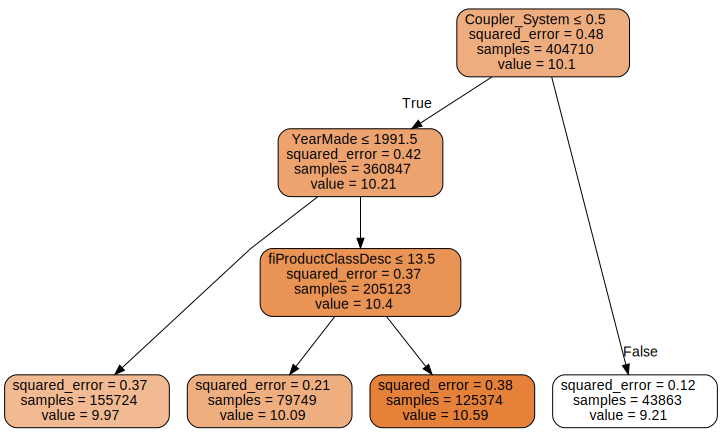

In [39]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [37]:
conda install conda-forge::dtreeviz

Channels:
 - defaults
 - conda-forge
Platform: linux-aarch64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


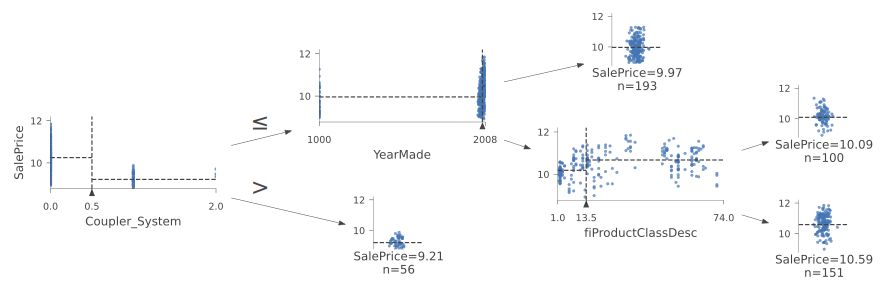

In [55]:
# from dtreeviz import *
# from dtreeviz.trees import *
# import dtreeviz
# from dtreeviz.trees import dtreeviz

samp_idx = np.random.permutation(len(y))[:500]
viz_model=dtreeviz.model(m,
                         X_train=xs.iloc[samp_idx],
                         y_train=y.iloc[samp_idx],
                         feature_names=xs.columns,
                         target_name=dep_var)

viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
               orientation='LR')


In [56]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


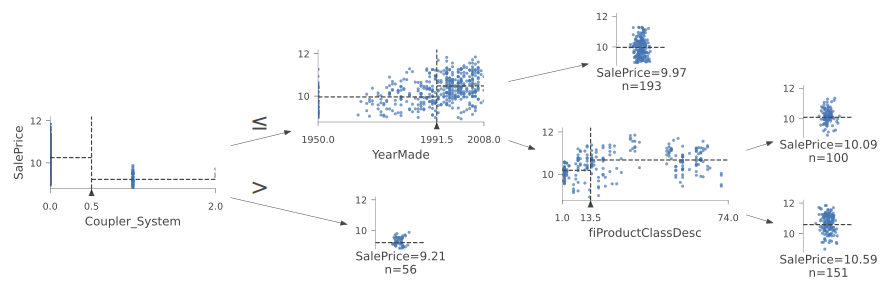

In [58]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

viz_model=dtreeviz.model(m,
                         X_train=xs.iloc[samp_idx],
                         y_train=y.iloc[samp_idx],
                         feature_names=xs.columns,
                         target_name=dep_var)

viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
               orientation='LR')

In [59]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [31]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [61]:
m_rmse(m, xs, y)

0.0

In [62]:
m_rmse(m, valid_xs, valid_y)

0.333452

In [63]:
m.get_n_leaves(), len(xs)

(324367, 404710)

In [64]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.243019, 0.309477)

In [65]:
m.get_n_leaves()

12432

In [29]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs.values, y)

In [78]:
m = rf(xs, y);

In [79]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names


(0.171459, 0.234027)

In [80]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/miniconda3/lib/python3.12/site-pac

In [81]:
r_mse(preds.mean(0), valid_y)

0.234027

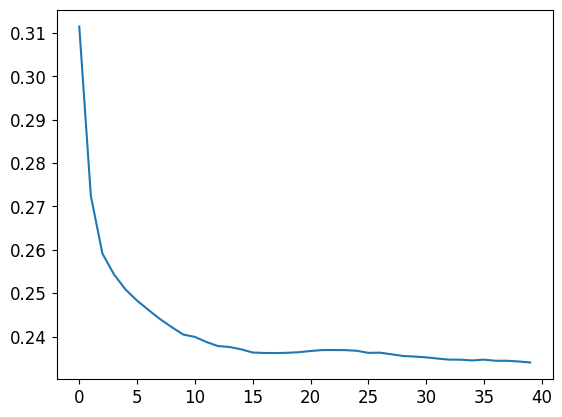

In [82]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [83]:
r_mse(m.oob_prediction_, y)

0.211466

In [84]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/root/miniconda3/lib/python3.12/site-pac

In [85]:
preds.shape

(40, 7988)

In [86]:
preds_std = preds.std(0)

In [87]:
preds_std[:5]

array([0.24235985, 0.14927351, 0.10642167, 0.24968261, 0.10935718])

In [79]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [89]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.171488
6,ProductSize,0.113265
30,Coupler_System,0.110150
7,fiProductClassDesc,0.073344
54,ModelID,0.060963
32,Hydraulics_Flow,0.051328
65,saleElapsed,0.050912
3,fiSecondaryDesc,0.042928
31,Grouser_Tracks,0.040547
12,Enclosure,0.037557


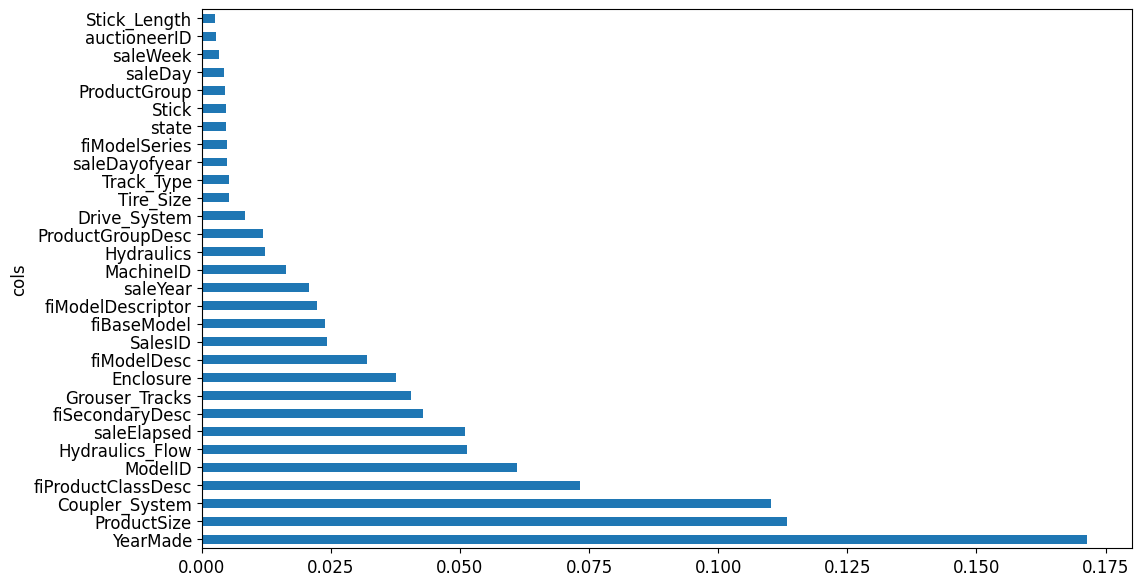

In [90]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [103]:
to_keep = fi[fi.imp>0.004].cols
len(to_keep)

27

In [104]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [105]:
m = rf(xs_imp, y)

In [106]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names


(0.174606, 0.233343)

In [107]:
len(xs.columns), len(xs_imp.columns)

(66, 27)

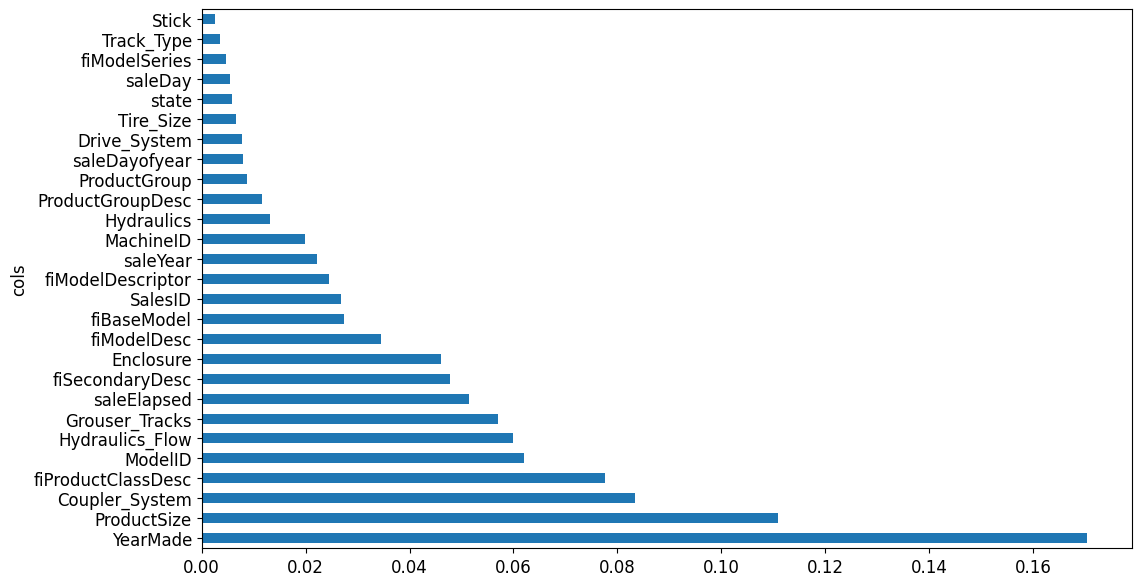

In [108]:
plot_fi(rf_feat_importance(m, xs_imp));

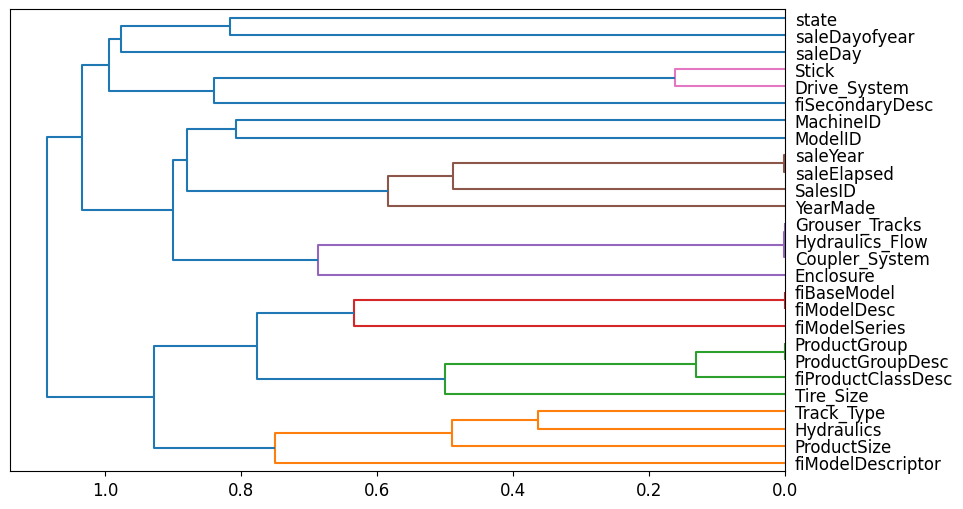

In [109]:
cluster_columns(xs_imp)

In [110]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [111]:
get_oob(xs_imp)

0.875497530469073

In [112]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8745005084794886,
 'saleElapsed': 0.8712535725390107,
 'ProductGroupDesc': 0.8758505120808255,
 'ProductGroup': 0.8759216712855354,
 'fiModelDesc': 0.8748507045284799,
 'fiBaseModel': 0.8749339817303791,
 'Hydraulics_Flow': 0.8759219764340707,
 'Grouser_Tracks': 0.8763186918762343,
 'Coupler_System': 0.876252557714488}

In [113]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8737553444733617

In [114]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [115]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [27]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [34]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names


(0.176109, 0.234277)

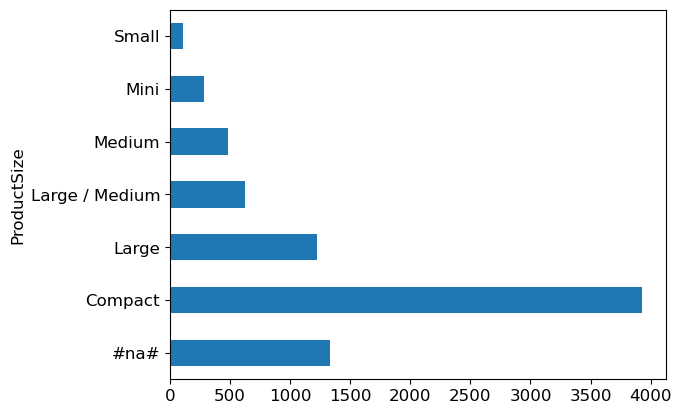

In [35]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

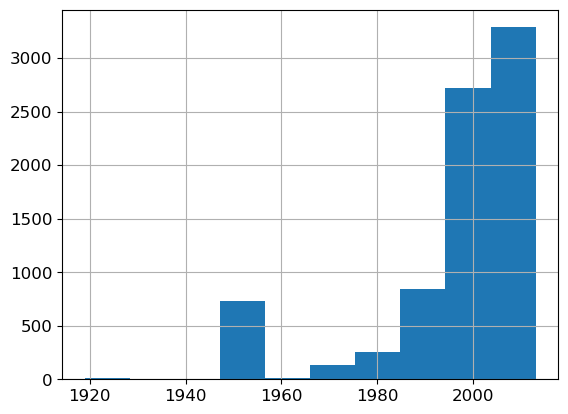

In [36]:
ax = valid_xs_final['YearMade'].hist()

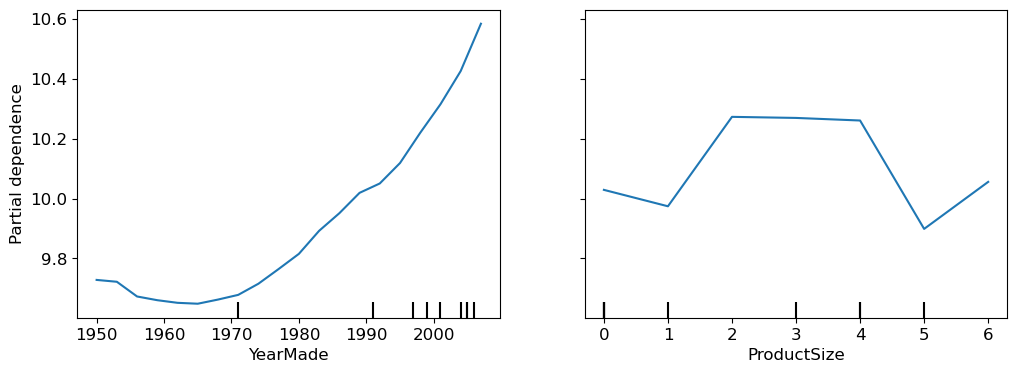

In [60]:
# from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
fig,ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(m, valid_xs_final, ['YearMade','ProductSize'], grid_resolution=20, ax=ax)


In [61]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [62]:
!pip install treeinterpreter
!pip install waterfallcharts

In [63]:
row = valid_xs_final.iloc[:5]

In [64]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [65]:
prediction[0], bias[0], contributions[0].sum()

(array([9.97714675]), 10.104284736365315, -0.12713798902220763)

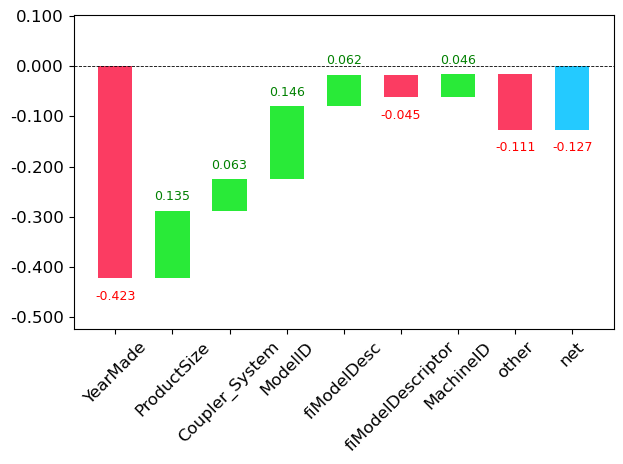

In [66]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

## Extrapolation and Neural Networks

In [67]:
np.random.seed(42)

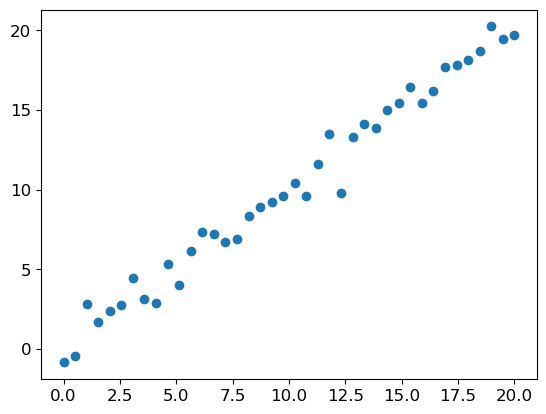

In [70]:
x_lin = torch.linspace(0,20,steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin)

In [75]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape, xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [76]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

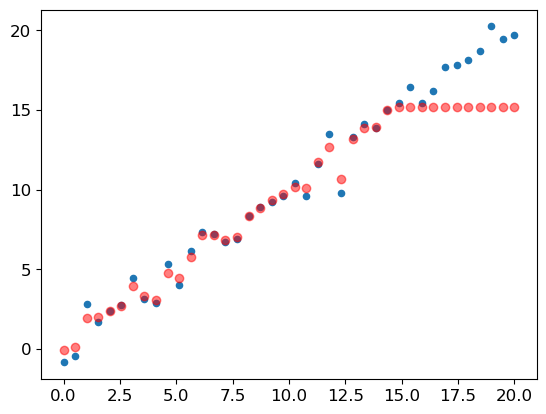

In [77]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

In [80]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
6,saleElapsed,0.482024
17,saleDayofyear,0.338938
10,SalesID,0.142233
12,MachineID,0.022344
22,saleDay,0.010989
0,YearMade,0.002358


In [81]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names


orig 0.235577


/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names


SalesID 0.233066


/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names


saleElapsed 0.238548
MachineID 0.234087


/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names


In [83]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names


0.23252

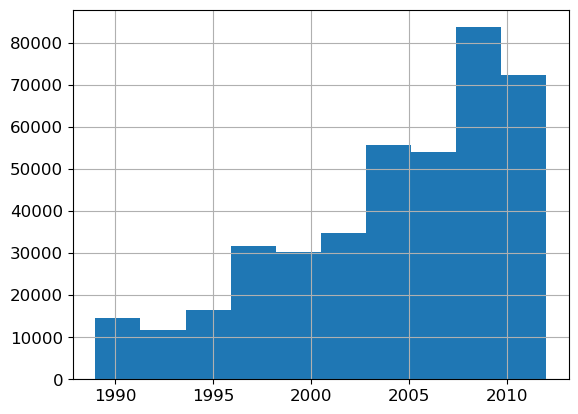

In [84]:
xs['saleYear'].hist();

In [85]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [86]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names


(0.160331, 0.231914)

### Using a Neural Network

In [90]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

/root/miniconda3/lib/python3.12/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [102]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [104]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [106]:
cont_nn

['saleElapsed']

In [107]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
Hydraulics_Flow          3
fiSecondaryDesc        177
Enclosure                6
fiModelDesc           5059
fiModelDescriptor      140
Hydraulics              12
Drive_System             4
Tire_Size               17
Track_Type               2
saleDayofyear          361
fiModelSeries          123
state                   53
Stick                    2
ProductGroup             6
saleDay                 31
dtype: int64

In [108]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names


(0.159942, 0.232679)

In [109]:
cat_nn.remove('fiModelDescriptor')

In [112]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [113]:
dls = to_nn.dataloaders(1024)

In [114]:
y = to_nn.train.y
y.min(),y.max()

(8.465899467468262, 11.863582611083984)

In [115]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0003981071640737355)

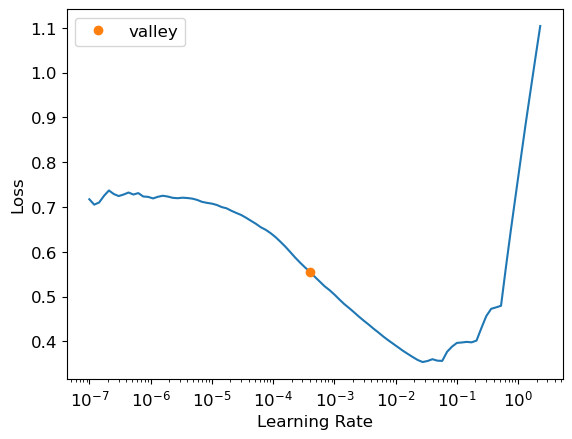

In [116]:
learn.lr_find()

In [117]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.058482,0.059099,00:10
1,0.047986,0.062268,00:10
2,0.041464,0.056236,00:10
3,0.035461,0.054474,00:10
4,0.033113,0.053624,00:10


In [118]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.231569

In [119]:
learn.save('nn')

Path('models/nn.pth')

In [120]:
tabular_learner??

Signature:
tabular_learner(
    dls: 'TabularDataLoaders',
    layers: 'list' = None,
    emb_szs: 'list' = None,
    config: 'dict' = None,
    n_out: 'int' = None,
    y_range: 'Tuple' = None,
    *,
    loss_func: 'callable | None' = None,
    opt_func: 'Optimizer | OptimWrapper' = <function Adam at 0xffff506a94e0>,
    lr: 'float | slice' = 0.001,
    splitter: 'callable' = <function trainable_params at 0xffff570c96c0>,
    cbs: 'Callback | MutableSequence | None' = None,
    metrics: 'callable | MutableSequence | None' = None,
    path: 'str | Path | None' = None,
    model_dir: 'str | Path' = 'models',
    wd: 'float | int | None' = None,
    wd_bn_bias: 'bool' = False,
    train_bn: 'bool' = True,
    moms: 'tuple' = (0.95, 0.85, 0.95),
    default_cbs: 'bool' = True,
)
Source:   
@delegates(Learner.__init__)
def tabular_learner(
        dls:TabularDataLoaders,
        layers:list=None, # Size of the layers generated by `LinBnDrop`
        emb_szs:list=None, # Tuples of `n_uniqu

In [121]:
TabularModel??

Init signature:
TabularModel(
    emb_szs: 'list',
    n_cont: 'int',
    out_sz: 'int',
    layers: 'list',
    ps: 'float | MutableSequence' = None,
    embed_p: 'float' = 0.0,
    y_range=None,
    use_bn: 'bool' = True,
    bn_final: 'bool' = False,
    bn_cont: 'bool' = True,
    act_cls=ReLU(inplace=True),
    lin_first: 'bool' = True,
)
Source:        
class TabularModel(Module):
    "Basic model for tabular data."
    def __init__(self, 
        emb_szs:list, # Sequence of (num_embeddings, embedding_dim) for each categorical variable
        n_cont:int, # Number of continuous variables
        out_sz:int, # Number of outputs for final `LinBnDrop` layer
        layers:list, # Sequence of ints used to specify the input and output size of each `LinBnDrop` layer
        ps:float|MutableSequence=None, # Sequence of dropout probabilities for `LinBnDrop`
        embed_p:float=0., # Dropout probability for `Embedding` layer
        y_range=None, # Low and high for `SigmoidRange` activa

In [122]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

/root/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names


In [123]:
r_mse(ens_preds,valid_y)

0.22187